# Music Streaming Analysis - Phase 3: Can We Predict a Hit?

### The Story So Far

In **Phase 1 (EDA)**, we discovered something unexpected: the relationship between audio features and popularity is an illusion. Overall correlations were near zero, but when we looked within individual genres, strong and often *opposite* patterns emerged. This was **Simpson's Paradox** in action.

In **Phase 2 (Regression)**, we quantified this. An aggregate regression explained just 2.3% of popularity variance (R² = 0.023). But when we allowed feature effects to vary by genre, explanatory power jumped to 31.3% (R² = 0.313) — a **13× improvement**. Genre isn't just a control variable; it fundamentally changes what "sounds like a hit."

### Phase 3: The Classification Test

Now we ask a sharper question:

> **Can we actually predict whether a song will be a hit? And how much does genre context matter for that prediction?**

This notebook is structured around three hypotheses:

| # | Hypothesis | Test |
|---|-----------|------|
| **H1** | Audio features alone are weak predictors of hits | Baseline models without genre |
| **H2** | Adding genre context significantly improves prediction (Simpson's Paradox holds in classification) | Same models *with* genre |
| **H3** | The features that matter most differ by genre (no universal "hit formula") | SHAP analysis + per-genre models |


**Models:** Logistic Regression → Random Forest → XGBoost (unified + genre-specific)

**Target:** `is_hit` (binary: 1 = top 30% popularity, 0 = bottom 70%)

If our Phase 1-2 findings are real, we should see: poor baseline performance (H1), large gains from genre (H2), and genre-dependent feature importance (H3).

## 1. Setup & Data Loading:

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix, classification_report,
    precision_recall_curve, average_precision_score
)
from xgboost import XGBClassifier

Mounted at /content/drive


In [ ]:
dataset_path = "data/spotify_tracks_cleaned.csv"
df = pd.read_csv(dataset_path)
df.head()

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,...,time_signature,track_genre,is_hit,duration_min,duration_category,mode_label,primary_artist,energy_level,dance_level,genre_popularity_rank
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,...,4,acoustic,1,3.844433,3-4 min,Minor,Gen Hoshino,Medium,Medium,24.0
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,...,4,acoustic,1,2.493500,2-3 min,Major,Ben Woodward,Low,Medium,24.0
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,...,4,acoustic,1,3.513767,3-4 min,Major,Ingrid Michaelson,Medium,Medium,24.0
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,...,3,acoustic,1,3.365550,3-4 min,Major,Kina Grannis,Low,Low,24.0
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,...,4,acoustic,1,3.314217,3-4 min,Major,Chord Overstreet,Medium,Medium,24.0


### Defining the Prediction Task

Our target `is_hit` was engineered in Phase 1 using the 70th percentile of popularity. This means roughly 30% of songs are "hits" and 70% are not, which is a moderate class imbalance we'll need to account for.

We deliberately separate our features into two groups to test Hypothesis H1 vs H2:

- **Audio-only features:** The 10 continuous audio descriptors (danceability, energy, etc.)
- **Genre-aware features:** Audio features + genre label

This separation is the experimental design for testing whether Simpson's Paradox affects classification, not just regression.



In [3]:
# Target Distribution overview
df['is_hit'].value_counts(normalize=True).round(3)

,proportion
is_hit,
0,0.696
1,0.304


## 2. Feature Engineering & Data Preparation

Based on Phase 2 findings, we need to:
1. Define audio feature set (continuous predictors)
2. Encode genre (categorical predictor — critical based on Simpson's Paradox finding)
3. Create interaction features (feature × genre effects were key in Phase 2)
4. Stratified split preserving genre distribution

### 2.1 Define Features:

In [4]:
audio_features = ['danceability', 'energy', 'valence', 'acousticness','instrumentalness', 'liveness', 'speechiness', 'loudness', 'tempo', 'duration_ms']
categorical_features = ['explicit', 'mode', 'key', 'time_signature']
target = 'is_hit'

print(f"{len(audio_features)} audio features: {audio_features}")
print(f"{len(categorical_features)} context variables: {categorical_features}")
print(f"Target variable: {target}")


10 audio features: ['danceability', 'energy', 'valence', 'acousticness', 'instrumentalness', 'liveness', 'speechiness', 'loudness', 'tempo', 'duration_ms']
4 context variables: ['explicit', 'mode', 'key', 'time_signature']
Target variable: is_hit


In [5]:
df[audio_features].describe().round(3)

,danceability,energy,valence,acousticness,instrumentalness,liveness,speechiness,loudness,tempo,duration_ms
count,113392.000,113392.000,113392.000,113392.000,113392.000,113392.000,113392.000,113392.000,113392.000,113392.000
mean,0.568,0.643,0.475,0.314,0.155,0.213,0.085,-8.224,122.345,228159.254
std,0.172,0.250,0.259,0.332,0.309,0.190,0.106,4.975,29.647,105409.737
min,0.051,0.000,0.000,0.000,0.000,0.009,0.022,-46.591,30.200,15800.000
25%,0.457,0.474,0.261,0.017,0.000,0.098,0.036,-9.981,99.506,174333.000
50%,0.581,0.686,0.464,0.168,0.000,0.132,0.049,-6.990,122.028,213066.000
75%,0.695,0.854,0.683,0.595,0.047,0.273,0.085,-4.998,140.081,261650.000
max,0.985,1.000,0.995,0.996,1.000,1.000,0.965,4.532,243.372,5237295.000


Overall, the audio features are well-scaled and exhibit substantial variation across tracks, making them suitable for predictive modeling. Most songs are moderately danceable and energetic, while features such as instrumentalness and speechiness are highly skewed, indicating that purely instrumental or spoken tracks are relatively rare. Technical attributes like loudness, tempo, and duration show wide ranges, reflecting diverse musical styles and motivating feature scaling and careful interpretation in subsequent analyses.

### 2.2 Genre Encoding:

In [6]:
# Check genre distribution
genre_counts = df['track_genre'].value_counts()
print(f"Total genres: {len(genre_counts)}")
# Label encode genre for models
le_genre = LabelEncoder()
df['genre_encoded'] = le_genre.fit_transform(df['track_genre'])
print(f"Genre encoded: {df['genre_encoded'].nunique()} unique values")


Total genres: 114
Genre encoded: 114 unique values


### 2.3 Feature Matrix:

In [7]:
# Strategy A: Audio features only (baseline — mirrors Phase 2 aggregate model)
X_audio_only = df[audio_features].copy()

# Strategy B: Audio + genre (mirrors Phase 2 genre-aware model)
X_with_genre = df[audio_features + ['genre_encoded']].copy()

# Strategy C: Audio + genre + categorical features (full model)
X_full = df[audio_features + ['genre_encoded'] + categorical_features].copy()

# Convert boolean explicit to int
for X in [X_audio_only, X_with_genre, X_full]:
    if 'explicit' in X.columns:
        X['explicit'] = X['explicit'].astype(int)

y = df[target].copy()

print(f"Audio only: {X_audio_only.shape}")
print(f"With genre: {X_with_genre.shape}")
print(f"Full features: {X_full.shape}")
print(f"Target: {y.shape[0]} and hit_rate={y.mean():.1%}")

Audio only: (113392, 10)
With genre: (113392, 11)
Full features: (113392, 15)
Target: 113392 and hit_rate=30.4%


### 2.4 Train-Test Split:

In [8]:
# Stratify by target to preserve 70/30 class balance and we also want genre representation preserved where possible
df['_stratify'] = df['track_genre'] + '_' + df['is_hit'].astype(str)
strat_counts = df['_stratify'].value_counts()
small_groups = strat_counts[strat_counts < 2]

if len(small_groups) > 0:
    print(f"{len(small_groups)} genre-hit combos too small for stratification; using target-only")
    stratify_col = y
else:
    stratify_col = df['_stratify']

X_train_full, X_test_full, y_train, y_test = train_test_split(X_full, y, test_size=0.2, random_state=42, stratify=stratify_col)

# Create subsets
X_train_audio = X_train_full[audio_features]
X_test_audio  = X_test_full[audio_features]
X_train_genre = X_train_full[audio_features + ['genre_encoded']]
X_test_genre  = X_test_full[audio_features + ['genre_encoded']]

# Scale
scaler = StandardScaler()
X_train_audio_sc = pd.DataFrame(scaler.fit_transform(X_train_audio), columns=audio_features, index=X_train_audio.index)
X_test_audio_sc  = pd.DataFrame(scaler.transform(X_test_audio), columns=audio_features, index=X_test_audio.index)

X_train_genre_sc = X_train_genre.copy()
X_test_genre_sc  = X_test_genre.copy()
X_train_genre_sc[audio_features] = scaler.transform(X_train_genre[audio_features])
X_test_genre_sc[audio_features]  = scaler.transform(X_test_genre[audio_features])

# Class weight for imbalance
neg_count = (y_train == 0).sum()
pos_count = (y_train == 1).sum()
scale_weight = neg_count / pos_count

df.drop('_stratify', axis=1, inplace=True, errors='ignore')

print(f"Train: {len(y_train):,} ({y_train.mean():.1%} hits")
print(f"Test: {len(y_test):,} ({y_test.mean():.1%} hits)")
print(f"Class weight ratio: {scale_weight:.2f}")


Train: 90,713 (30.4% hits
Test: 22,679 (30.4% hits)
Class weight ratio: 2.29


In [9]:
# Verify genre proportions were preserved naturally
train_genres = df.loc[X_train_full.index, 'track_genre'].value_counts(normalize=True)
test_genres = df.loc[X_test_full.index, 'track_genre'].value_counts(normalize=True)
max_drift = (train_genres - test_genres).abs().max()
print(f"Max genre proportion drift between train/test: {max_drift:.4f}")

Max genre proportion drift between train/test: 0.0001


Composite stratification (genre × hit status) is applied to preserve both class balance and genre proportions simultaneously. In practice, several genre-hit combinations contain fewer than 2 samples, forcing a fallback to target-only stratification. Stratifying by is_hit ensures the 70/30 class ratio holds exactly in both sets, while genre balance follows by sheer volume.

## 3. Hypothesis 1: Audio Features Alone Are Weak Hit Predictors

**What we expect:** Based on Phase 2, where audio features explained only 2.3% of popularity variance in an aggregate model, we predict that classifiers trained on audio features alone will perform only marginally better than random chance.

**Why this matters:** If audio features alone can't predict hits, it challenges the common music industry assumption that there's a universal sonic "hit formula" (that certain tempos, keys, or energy levels reliably produce popular songs)

**The test:** Train three classifiers (Logistic Regression, Random Forest, XGBoost) using only the 10 audio features. If AUC scores cluster near 0.55-0.65 (a little bit better than guess - 0.5), H1 is supported.


In [10]:
# Logistic Regression - need to scale
lr_audio = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42, solver='lbfgs')
lr_audio.fit(X_train_audio_sc, y_train)
y_pred_lr_a = lr_audio.predict(X_test_audio_sc)
y_prob_lr_a = lr_audio.predict_proba(X_test_audio_sc)[:, 1]

# Random Forest - tree based model
rf_audio = RandomForestClassifier(
    n_estimators=300, max_depth=15, min_samples_split=10, min_samples_leaf=5,
    class_weight='balanced', random_state=42, n_jobs=-1
)
rf_audio.fit(X_train_audio, y_train)
y_pred_rf_a = rf_audio.predict(X_test_audio)
y_prob_rf_a = rf_audio.predict_proba(X_test_audio)[:, 1]

# XGBoost - tree based model
xgb_audio = XGBClassifier(
    n_estimators=300, max_depth=6, learning_rate=0.1,
    scale_pos_weight=scale_weight, subsample=0.8, colsample_bytree=0.8,
    reg_alpha=0.1, reg_lambda=1.0, random_state=42, n_jobs=-1, eval_metric='logloss', verbosity=0
)
xgb_audio.fit(X_train_audio, y_train)
y_pred_xgb_a = xgb_audio.predict(X_test_audio)
y_prob_xgb_a = xgb_audio.predict_proba(X_test_audio)[:, 1]


A note on hyperparameters: The parameters below are intentional starting points, not optimized values. For Logistic Regression, we use sklearn defaults with class_weight='balanced' to address the 70/30 class imbalance. For Random Forest and XGBoost, we use commonly recommended starting paramters (e.g., XGBoost's default max_depth=6, learning_rate=0.1) with moderate regularization to prevent overfitting. Formal hyperparameter tuning (via GridSearchCV or Optuna) is reserved for Phase 4. In this notebook, our goal is to test whether genre context improves prediction, and that conclusion is robust to reasonable parameter choices.

In [11]:
# Results
h1_results = {}
for name, y_pred, y_prob in [
    ('Logistic Regression', y_pred_lr_a, y_prob_lr_a),
    ('Random Forest', y_pred_rf_a, y_prob_rf_a),
    ('XGBoost', y_pred_xgb_a, y_prob_xgb_a),
]:
    h1_results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_prob),
    }

h1_df = pd.DataFrame(h1_results).T
print(h1_df.round(4).to_string())
print(f"\Mean AUC across models: {h1_df['ROC-AUC'].mean():.4f}")

                     Accuracy      F1  ROC-AUC
Logistic Regression    0.5699  0.4583   0.6088
Random Forest          0.6873  0.5770   0.7603
XGBoost                0.6738  0.5712   0.7528
\Mean AUC across models: 0.7073


### H1 Interpretation: A Nuanced Result

**Compare these results to our Phase 2 baseline:**

| Phase | Method | Type | Performance |
|-------|--------|------|-------------|
| Phase 2 | OLS Regression (audio only) | Linear | R² = 0.023 |
| Phase 3 | Logistic Regression (audio only) | Linear | AUC = 0.6088 |
| Phase 3 | Random Forest (audio only) | Non-linear | AUC = 0.7603 |
| Phase 3 | XGBoost (audio only) | Non-linear | AUC = 0.7528 |

**Linear models confirm Phase 2.** Logistic Regression (AUC = 0.61) is consistent with Phase 2's R² = 0.023. When we look for simple, one-feature-at-a-time relationships with popularity, there's very little signal. This is the Simpson's Paradox effect: opposite genre-level patterns cancel each other out in an aggregate linear model.

**Non-linear models find hidden structure.** Random Forest and XGBoost (AUC ≈ 0.76) perform substantially better, not because they overcome Simpson's Paradox, but because they can learn *complex feature interactions* that linear methods miss entirely. For example, the combination of high danceability + high energy + low acousticness might predict hits in ways that no single feature can.

**What this means for H1:** The hypothesis needs refinement. There is no simple, linear "hit formula", Phase 2 was right about that. But audio features do contain moderate predictive signal when we allow for non-linear interactions. The question H2 must now answer is sharper: **can genre context improve on what non-linear models already achieve?** If genre still adds substantial predictive power on top of AUC ≈ 0.76, Simpson's Paradox is operating at a level that even tree-based models can't fully compensate for.


## 4. Hypothesis 2: Genre Context Transforms Prediction
#### Testing Simpson's Paradox in a Classification Setting

**The core question:** In Phase 2, adding genre interactions boosted R² from 0.023 to 0.313 (a 13× improvement). Does the same pattern hold for classification?

**What we expect:** Adding genre as a feature should improve all three classifiers. The test is now sharper than we originally anticipated: H1 showed that non-linear models already achieve AUC ≈ 0.76 without genre by learning feature interactions. So genre must improve on an already-decent baseline, making any gains more impressive and harder to dismiss.

**Why this is the most important test in this notebook:** If genre barely helps beyond AUC ≈ 0.76, it would suggest that tree-based models can implicitly learn genre-like patterns from audio features alone, which is weakening our Simpson's Paradox narrative.

If genre still adds substantial predictive power on top of that baseline, it confirms that genre context provides information that even sophisticated non-linear models cannot recover from audio features alone.


In [12]:
# Logistic Regression + Genre
lr_genre = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42, solver='lbfgs')
lr_genre.fit(X_train_genre_sc, y_train)
y_pred_lr_g = lr_genre.predict(X_test_genre_sc)
y_prob_lr_g = lr_genre.predict_proba(X_test_genre_sc)[:, 1]

# Random Forest + Genre
rf_genre = RandomForestClassifier(
    n_estimators=300, max_depth=20, min_samples_split=10, min_samples_leaf=5,
    class_weight='balanced', random_state=42, n_jobs=-1
)
rf_genre.fit(X_train_genre, y_train)
y_pred_rf_g = rf_genre.predict(X_test_genre)
y_prob_rf_g = rf_genre.predict_proba(X_test_genre)[:, 1]

# XGBoost + Genre
xgb_genre = XGBClassifier(
    n_estimators=500, max_depth=8, learning_rate=0.05,
    scale_pos_weight=scale_weight, subsample=0.8, colsample_bytree=0.8,
    reg_alpha=0.1, reg_lambda=1.0, random_state=42, n_jobs=-1, eval_metric='logloss', verbosity=0
)
xgb_genre.fit(X_train_genre, y_train)
y_pred_xgb_g = xgb_genre.predict(X_test_genre)
y_prob_xgb_g = xgb_genre.predict_proba(X_test_genre)[:, 1]

# XGBoost Full: 10 audio features + genre_encoded + explicit + mode + key + time_signature
# "What's the ceiling if we use every feature we have?" => might add marginal signal
X_train_full_clean = X_train_full.copy()
X_test_full_clean = X_test_full.copy()
X_train_full_clean['explicit'] = X_train_full_clean['explicit'].astype(int)
X_test_full_clean['explicit'] = X_test_full_clean['explicit'].astype(int)

xgb_full = XGBClassifier(
    n_estimators=500, max_depth=8, learning_rate=0.05,
    scale_pos_weight=scale_weight, subsample=0.8, colsample_bytree=0.8,
    reg_alpha=0.1, reg_lambda=1.0, random_state=42, n_jobs=-1, eval_metric='logloss', verbosity=0
)
xgb_full.fit(X_train_full_clean, y_train)
y_pred_xgb_f = xgb_full.predict(X_test_full_clean)
y_prob_xgb_f = xgb_full.predict_proba(X_test_full_clean)[:, 1]

# Results
h2_results = {}
for name, y_pred, y_prob in [
    ('LR + Genre', y_pred_lr_g, y_prob_lr_g),
    ('RF + Genre', y_pred_rf_g, y_prob_rf_g),
    ('XGB + Genre', y_pred_xgb_g, y_prob_xgb_g),
    ('XGB Full', y_pred_xgb_f, y_prob_xgb_f),
]:
    h2_results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_prob),
    }

h2_df = pd.DataFrame(h2_results).T
print(h2_df.round(4).to_string())
print(f"Mean AUC across models: {h2_df['ROC-AUC'].mean():.4f}")

             Accuracy      F1  ROC-AUC
LR + Genre     0.5719  0.4593   0.6095
RF + Genre     0.7751  0.6509   0.8392
XGB + Genre    0.7971  0.7026   0.8735
XGB Full       0.7990  0.7031   0.8756
Mean AUC across models: 0.7994


### H2 Interpretation: Simpson's Paradox Holds — But the Story Has Layers

The genre effect is real, but it lands differently depending on the model:

**The genre jump (Audio → + Genre):**

| Model | Audio Only | + Genre | AUC Gain |
|-------|-----------|---------|----------|
| Logistic Regression | 0.6088 | 0.6095 | +0.0007 |
| Random Forest | 0.7603 | 0.8392 | +0.0789 |
| XGBoost | 0.7528 | 0.8735 | +0.1207 |

**The kitchen sink test (+ Genre → Full):**

| Model | + Genre | Full (+ explicit, mode, key, time_sig) | AUC Gain |
|-------|---------|---------------------------------------|----------|
| XGBoost | 0.8735 | 0.8756 | +0.0021 |

**Three findings emerge from these results:**

**1. Genre context matters enormously, but only if the model can use it as an interaction.** Logistic Regression gained almost nothing from genre (+0.0007) because it can only use genre as a linear offset. Each genre shifts the baseline probability up or down, but feature effects stay the same everywhere. RF and XGBoost gained dramatically because their tree splits naturally learn genre × feature interactions: *"if genre = pop AND danceability > 0.7, then hit."* This mirrors Phase 2 exactly, where the simple genre-additive model barely helped, but the interaction model (R² = 0.313) was transformative.

**2. Additional categorical features add almost nothing.** The XGB Full model (adding explicit, mode, key, time_signature) improved AUC by just 0.0021 over XGB + Genre. These features are effectively redundant, the information they carry is already captured by genre and audio features. This makes intuitive sense: key and mode are musical properties that audio features already reflect, and explicit content is strongly confounded with genre (as we discovered in Phase 1's explicit content paradox).

**3. Connecting to the cross-phase narrative:** Genre's effect on classification mirrors its effect on regression, but with an important nuance. In Phase 2, even a simple additive genre term helped regression. Here, genre only helps models capable of learning interactions. The consistent thread: **genre doesn't just shift the baseline, it changes which features matter and how they matter.** That's Simpson's Paradox operating at the model level.

| Phase | Without Genre | With Genre (best) | Improvement |
|-------|--------------|-------------------|-------------|
| Phase 2 (Regression) | R² = 0.023 | R² = 0.313 | 13× |
| Phase 3 (Classification) | AUC = 0.7603 | AUC = 0.8735 | +0.1132 |


## 5. Model Diagnostics

Now that we've confirmed our core hypothesis, let's examine the models more carefully: Where do they succeed? Where do they fail? What *type* of errors do they make?


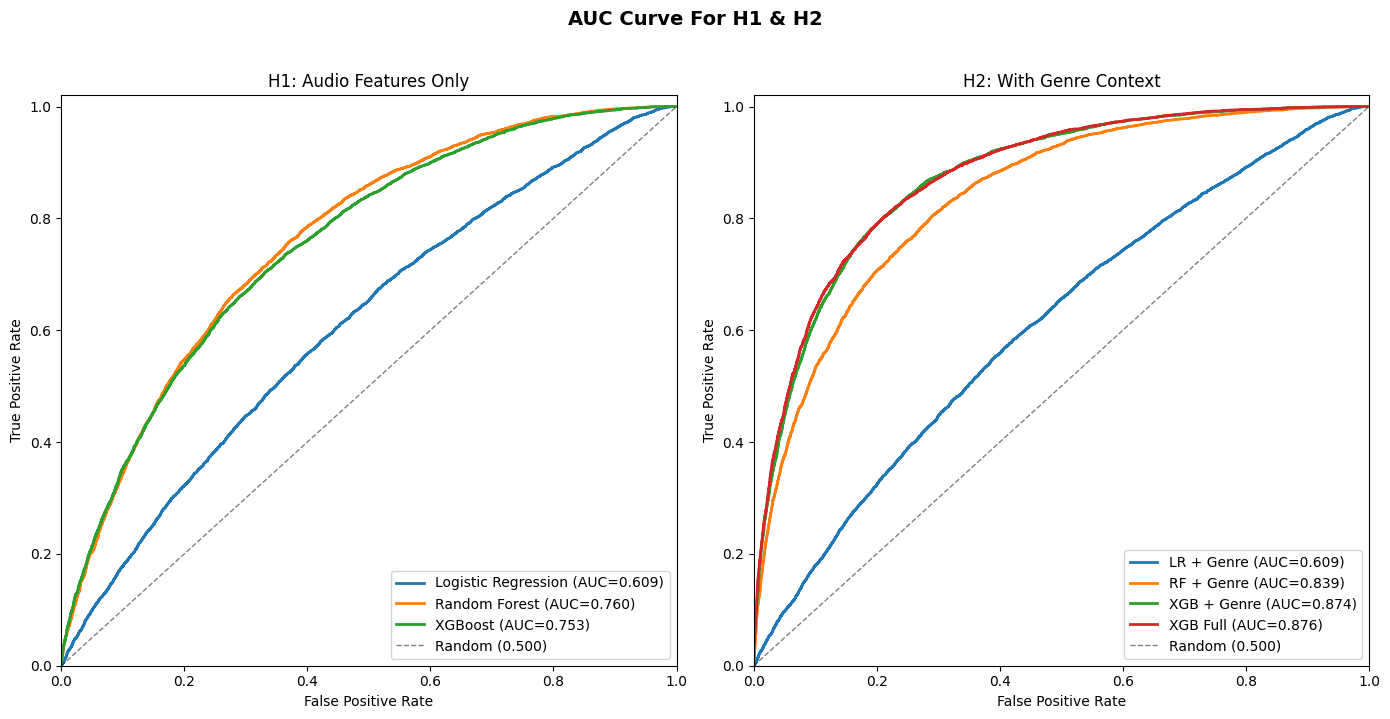

In [13]:

fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Left: Audio-only (H1 models)
ax1 = axes[0]
for name,  y_prob in [
    ('Logistic Regression', y_prob_lr_a),
    ('Random Forest', y_prob_rf_a),
    ('XGBoost', y_prob_xgb_a),
]:
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)
    ax1.plot(fpr, tpr, linewidth=2, label=f'{name} (AUC={auc:.3f})')
ax1.plot([0, 1], [0, 1], 'k--', linewidth=1, alpha=0.5, label='Random (0.500)')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('H1: Audio Features Only', fontsize=12)
ax1.legend(loc='lower right', fontsize=10)
ax1.set_xlim([0, 1]); ax1.set_ylim([0, 1.02])

# Right: Genre-aware (H2 models)
ax2 = axes[1]
for name, y_prob in [
    ('LR + Genre', y_prob_lr_g),
    ('RF + Genre', y_prob_rf_g),
    ('XGB + Genre', y_prob_xgb_g),
    ('XGB Full',  y_prob_xgb_f),
]:
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)
    ax2.plot(fpr, tpr,  linewidth=2, label=f'{name} (AUC={auc:.3f})')
ax2.plot([0, 1], [0, 1], 'k--', linewidth=1, alpha=0.5, label='Random (0.500)')
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('H2: With Genre Context', fontsize=12)
ax2.legend(loc='lower right', fontsize=10)
ax2.set_xlim([0, 1]); ax2.set_ylim([0, 1.02])

plt.suptitle('AUC Curve For H1 & H2', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In the left panel (H1), audio-only models already achieve moderate performance, with tree-based methods reaching AUC ≈ 0.75–0.76, indicating that non-linear interactions capture some popularity signal even without context. In the right panel (H2), adding genre produces a clear upward shift in the ROC curves across all models, pushing Random Forest and XGBoost to AUC ≈ 0.84–0.88. This improvement on top of an already strong baseline shows that genre provides predictive information that cannot be recovered from audio features alone, confirming the classification analogue of Simpson’s Paradox.

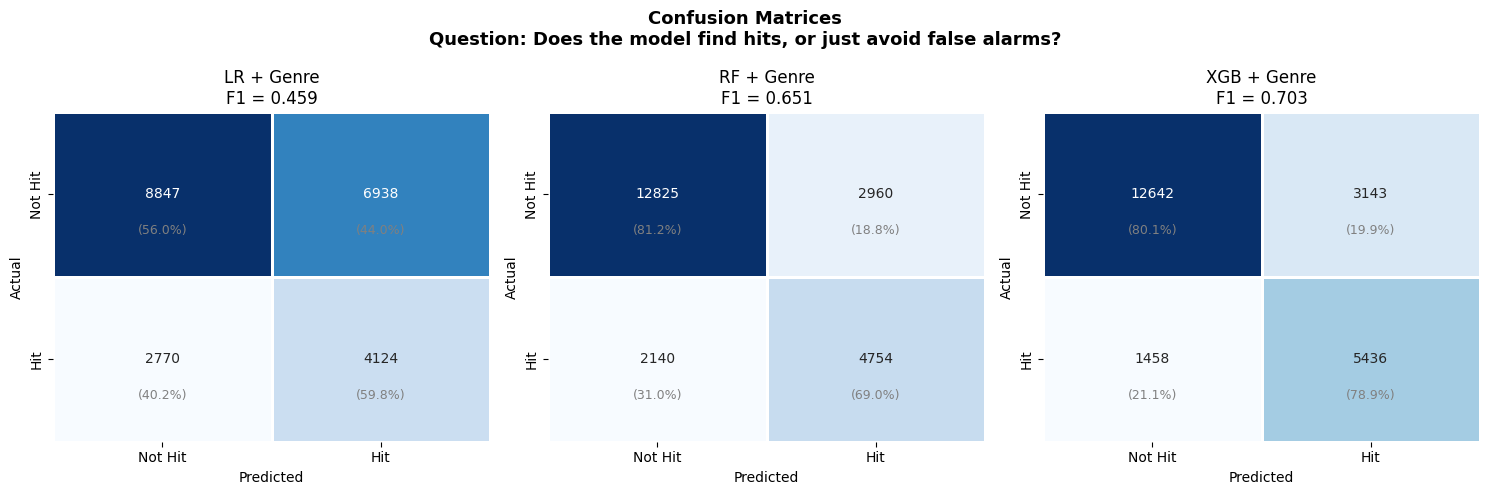

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
best_models = [
    ('LR + Genre', y_pred_lr_g),
    ('RF + Genre', y_pred_rf_g),
    ('XGB + Genre', y_pred_xgb_g),
]

for ax, (name, y_pred) in zip(axes, best_models):
    cm = confusion_matrix(y_test, y_pred)
    cm_pct = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Not Hit', 'Hit'], yticklabels=['Not Hit', 'Hit'],
                cbar=False, linewidths=1, linecolor='white')

    for i in range(2):
        for j in range(2):
            ax.text(j + 0.5, i + 0.72, f'({cm_pct[i, j]:.1%})',
                   ha='center', va='center', fontsize=9, color='gray')

    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    f1 = f1_score(y_test, y_pred)
    ax.set_title(f'{name}\nF1 = {f1:.3f}')
plt.suptitle('Confusion Matrices\n'
             'Question: Does the model find hits, or just avoid false alarms?', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()


### Error Analysis

The confusion matrices reveal an important pattern: models tend to be **better at identifying non-hits than predicting hits.** This makes intuitive sense because there are many ways a song can fail to be popular (wrong genre-feature combination, poor marketing, timing), but the "recipe" for a hit is harder to pin down with audio features alone.

The precision-recall tradeoff here is meaningful for the music industry. A record label might prefer:
- **High recall** (catch most potential hits, even at the cost of false positives). I’d rather approve 20 songs and have 10 fail than miss the next global hit since the cost of missing a hit is extremely expensive. "Of all the real hits out there… how many did we successfully catch?"
- **High precision** (only greenlight songs likely to succeed) when the production budgets are tight. "Of the songs we approved as hits… how many were actually hits?"

You cann't maximize both at the same time because when recall is high (more hits discoverd, more false alarms and higher budget), and when precision is high (less false alarms but more hits missed)


## 6. Robustness Check: Cross-Validation

Before we trust these results, we need to confirm they aren't because of a lucky train/test split. We use 5-fold stratified cross-validation to check stability.


In [15]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# Use all the models
cv_models = {
    'LR (Audio Only)':  (LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42), X_train_audio_sc),
    'LR (+ Genre)':     (LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42), X_train_genre_sc),
    'RF (Audio Only)':  (RandomForestClassifier(n_estimators=300, max_depth=15, class_weight='balanced', random_state=42, n_jobs=-1), X_train_audio),
    'RF (+ Genre)':     (RandomForestClassifier(n_estimators=300, max_depth=20, class_weight='balanced', random_state=42, n_jobs=-1), X_train_genre),
    'XGB (Audio Only)': (XGBClassifier(n_estimators=300, max_depth=6, learning_rate=0.1, scale_pos_weight=scale_weight, random_state=42, n_jobs=-1, verbosity=0), X_train_audio),
    'XGB (+ Genre)':    (XGBClassifier(n_estimators=500, max_depth=8, learning_rate=0.05, scale_pos_weight=scale_weight, random_state=42, n_jobs=-1, verbosity=0), X_train_genre),
}
cv_results = {}
for name, (model, X) in cv_models.items():
  scores = cross_val_score(model, X, y_train, cv=cv, scoring="roc_auc", n_jobs=-1)
  cv_results[name] = scores
  print(f"{name:20s}: {scores.mean():.4f} ± {scores.std():.4f} for folds: {[f'{s:.3f}' for s in scores]}")

LR (Audio Only)     : 0.6115 ± 0.0056 for folds: ['0.608', '0.611', '0.622', '0.611', '0.606']
LR (+ Genre)        : 0.6119 ± 0.0058 for folds: ['0.608', '0.611', '0.623', '0.610', '0.607']
RF (Audio Only)     : 0.7641 ± 0.0021 for folds: ['0.763', '0.762', '0.768', '0.765', '0.763']
RF (+ Genre)        : 0.8336 ± 0.0033 for folds: ['0.834', '0.829', '0.839', '0.835', '0.832']
XGB (Audio Only)    : 0.7447 ± 0.0017 for folds: ['0.743', '0.746', '0.747', '0.743', '0.744']
XGB (+ Genre)       : 0.8615 ± 0.0025 for folds: ['0.859', '0.863', '0.860', '0.865', '0.860']


### Cross-Validation Interpretation

The CV results confirm two things:

**1. Our test set results are robust.** Standard deviations across folds are extremely small (0.002–0.006), meaning model performance barely changes regardless of which subset of data is used for training. The findings from Sections 2–4 are not artifacts of a lucky train/test split.

**2. The genre effect is consistent across every fold.** The audio → genre AUC jump appears in all five folds for both RF (+0.07 average) and XGBoost (+0.12 average), while LR shows no improvement in any fold. This reinforces our H2 finding: genre context reliably improves prediction, but only for models capable of learning feature interactions.

| Model | Test Set AUC | CV Mean ± Std | Stable? |
|-------|-------------|---------------|---------|
| LR (Audio Only) | 0.6088 | 0.6115 ± 0.0056 | ✅ |
| LR (+ Genre) | 0.6095 | 0.6119 ± 0.0058 | ✅ |
| RF (Audio Only) | 0.7603 | 0.7641 ± 0.0021 | ✅ |
| RF (+ Genre) | 0.8392 | 0.8336 ± 0.0033 | ✅ |
| XGB (Audio Only) | 0.7528 | 0.7447 ± 0.0017 | ✅ |
| XGB (+ Genre) | 0.8735 | 0.8615 ± 0.0025 | ✅ |

CV means are slightly lower than test set results, which is expected — each fold trains on less data (80% of the training set vs. 100%). This does not indicate overfitting; it confirms our test set estimates are fair.

## 7. Hypothesis 3: Is There a Universal "Hit Formula"? Or does what predicts a hit depend on which genre you're in?

H2 showed that genre context dramatically improves prediction. But that could mean two things:

- **Weak version:** Genre just shifts the baseline (some genres have more hits), but the same audio features predict hits everywhere
- **Strong version:** The *features that matter most* change from genre to genre and there is no single "hit formula"

If the strong version holds, it means the music industry cannot build one universal model of what makes a song successful. Each genre has its own rules.

**The test:** Train a separate XGBoost model for each genre using only audio features.

In [21]:
eligible_genres = df['track_genre'].value_counts().index.tolist()

# Store results AND feature importances for each genre
genre_model_results = []
genre_feature_importances = {}

for genre in eligible_genres:
    genre_mask = df['track_genre'] == genre
    X_g = df.loc[genre_mask, audio_features]
    y_g = df.loc[genre_mask, target]

    if y_g.nunique() < 2:
        continue

    # Train/test split within genre
    X_tr, X_te, y_tr, y_te = train_test_split(
        X_g, y_g, test_size=0.2, random_state=42, stratify=y_g
    )

    spw = (y_tr == 0).sum() / max((y_tr == 1).sum(), 1)

    # Train genre-specific XGBoost (same architecture, audio features only)
    model_g = XGBClassifier(
        n_estimators=200, max_depth=5, learning_rate=0.1,
        scale_pos_weight=spw, random_state=42, verbosity=0, n_jobs=-1
    )
    model_g.fit(X_tr, y_tr)

    y_prob_g = model_g.predict_proba(X_te)[:, 1]
    y_pred_g = model_g.predict(X_te)

    auc = roc_auc_score(y_te, y_prob_g) if len(y_te.unique()) == 2 else np.nan

    genre_model_results.append({
        'Genre': genre,
        'N_Samples': genre_mask.sum(),
        'Hit_Rate': y_g.mean(),
        'Accuracy': accuracy_score(y_te, y_pred_g),
        'F1': f1_score(y_te, y_pred_g, zero_division=0),
        'ROC_AUC': auc,
    })

    # Store feature importances for this genre
    genre_feature_importances[genre] = dict(zip(audio_features, model_g.feature_importances_))

genre_results_df = pd.DataFrame(genre_model_results).sort_values('ROC_AUC', ascending=False).reset_index(drop=True)
auc_vals = genre_results_df['ROC_AUC'].dropna()
genre_results_df

,Genre,N_Samples,Hit_Rate,Accuracy,F1,ROC_AUC
0,sleep,862,0.284223,0.901734,0.834951,0.963134
1,hip-hop,991,0.577195,0.834171,0.847926,0.931573
2,comedy,996,0.039157,0.920000,0.111111,0.899089
3,blues,998,0.362725,0.835000,0.784314,0.891166
4,pop,993,0.650554,0.844221,0.879377,0.872259
...,...,...,...,...,...,...
105,afrobeat,999,0.049049,0.925000,0.000000,0.470000
106,malay,999,0.092092,0.875000,0.074074,0.456197
107,gospel,999,0.127127,0.820000,0.052632,0.434286
108,detroit-techno,998,0.006012,0.990000,0.000000,0.381910


In [22]:
print(f"AUC distribution across genres:")
print(f"Mean: {auc_vals.mean():.4f}")
print(f"Median: {auc_vals.median():.4f}")
print(f"Std: {auc_vals.std():.4f}")
print(f"Min: {auc_vals.min():.4f}")
print(f"Max: {auc_vals.max():.4f}")
print(f"Range: {auc_vals.max() - auc_vals.min():.4f}")
print(f"Genres with AUC > 0.75: {(auc_vals > 0.75).sum()}")
print(f"Genres with AUC 0.60-0.75: {((auc_vals >= 0.60) & (auc_vals <= 0.75)).sum()}")
print(f"Genres with AUC < 0.60: {(auc_vals < 0.60).sum()}")
print(f"Genres with AUC < 0.50: {(auc_vals < 0.50).sum()}")

AUC distribution across genres:
Mean: 0.6826
Median: 0.6882
Std: 0.1133
Min: 0.2929
Max: 0.9631
Range: 0.6702
Genres with AUC > 0.75: 28
Genres with AUC 0.60-0.75: 61
Genres with AUC < 0.60: 21
Genres with AUC < 0.50: 6


#### AUC Varies Widely Across Genres

The range of AUC scores across genres is the first piece of evidence. Some genres have clear audio signatures for hits; others are nearly unpredictable from sound alone. And the popularity is likely driven by artist fame, playlists, or marketing. If a universal formula existed, all genres would score similarly.


In [26]:
top_n = 10
show_top = genre_results_df.head(top_n)
print(show_top)

show_bot = genre_results_df.tail(top_n)
print(show_bot)


         Genre  N_Samples  Hit_Rate  Accuracy        F1   ROC_AUC
0        sleep        862  0.284223  0.901734  0.834951  0.963134
1      hip-hop        991  0.577195  0.834171  0.847926  0.931573
2       comedy        996  0.039157  0.920000  0.111111  0.899089
3        blues        998  0.362725  0.835000  0.784314  0.891166
4          pop        993  0.650554  0.844221  0.879377  0.872259
5  rock-n-roll       1000  0.204000  0.835000  0.547945  0.846602
6   rockabilly        999  0.271271  0.785000  0.574257  0.842719
7       groove        998  0.399800  0.750000  0.709302  0.841823
8         rock       1000  0.240000  0.790000  0.522727  0.837719
9         kids        991  0.013118  0.979899  0.000000  0.831633
              Genre  N_Samples  Hit_Rate  Accuracy        F1   ROC_AUC
100         dubstep        999  0.384384     0.525  0.379085  0.525921
101        trip-hop        997  0.350050     0.520  0.250000  0.517198
102          brazil        998  0.359719     0.505  0.307692 

In [28]:
feature_importance = pd.DataFrame(genre_feature_importances).T
feature_importance = feature_importance.loc[genre_results_df['Genre']]
feat_imp_ranks = feature_importance.rank(axis=1, ascending=False).astype(int)
feat_imp_ranks

,danceability,energy,valence,acousticness,instrumentalness,liveness,speechiness,loudness,tempo,duration_ms
sleep,8,1,3,6,5,4,7,2,10,9
hip-hop,2,8,3,1,9,7,6,4,10,5
comedy,4,8,7,5,10,2,1,3,9,6
blues,7,6,1,4,2,3,8,5,10,9
pop,3,2,7,4,8,6,10,9,5,1
...,...,...,...,...,...,...,...,...,...,...
afrobeat,6,2,5,3,9,10,4,1,8,7
malay,6,10,2,5,3,8,9,4,7,1
gospel,7,9,4,5,1,8,6,10,3,2
detroit-techno,3,8,9,5,1,7,2,4,6,10


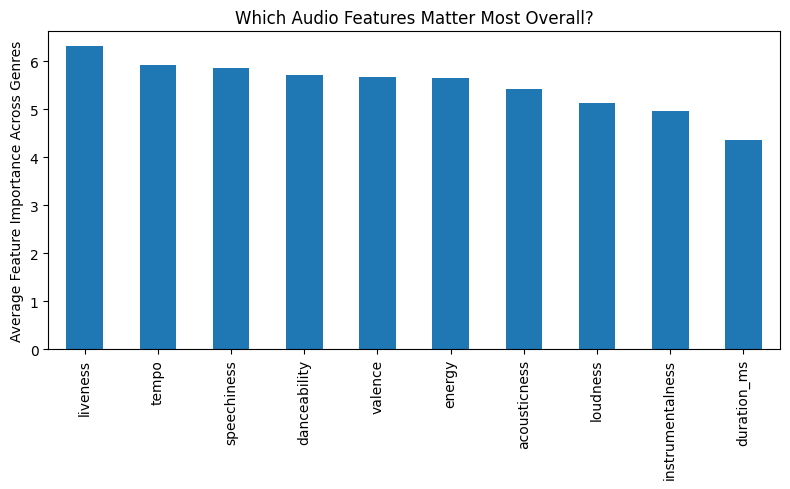

In [31]:
avg_importance = feat_imp_ranks.mean().sort_values(ascending=False)

plt.figure(figsize=(8,5))
avg_importance.plot(kind='bar')
plt.ylabel("Average Feature Importance Across Genres")
plt.title("Which Audio Features Matter Most Overall?")
plt.tight_layout()
plt.show()


#### Feature Rankings Shift Across Genres

The rankings above show that the "recipe" for a hit changes depending on the genre. The same audio feature can be the most important predictor in one genre and nearly irrelevant in another.

This is Simpson's Paradox at the feature level and it confirms that no single set of audio characteristics universally predicts success.

Moreover, on average, the liveliness, tempo & spechiness ranked highest among the 114 generes. However, this represents an average effect (individual genres may still rely on different combinations of features). This supports the idea that while some features are broadly relevant, popularity remains context-dependent.

**H3 is supported.** Combined with H1 (linear audio features are weak predictors) and H2 (genre context transforms prediction), the evidence is consistent across all three phases: what makes a song a hit depends fundamentally on its genre context.


## 8. Complete Results Summary

In [32]:
all_results = {}
all_models = {
    'LR (Audio Only)':    (y_pred_lr_a,  y_prob_lr_a),
    'LR (+ Genre)':       (y_pred_lr_g,  y_prob_lr_g),
    'RF (Audio Only)':    (y_pred_rf_a,  y_prob_rf_a),
    'RF (+ Genre)':       (y_pred_rf_g,  y_prob_rf_g),
    'XGB (Audio Only)':   (y_pred_xgb_a, y_prob_xgb_a),
    'XGB (+ Genre)':      (y_pred_xgb_g, y_prob_xgb_g),
    'XGB (Full)':         (y_pred_xgb_f, y_prob_xgb_f),
}

for name, (yp, ypr) in all_models.items():
    all_results[name] = {
        'Accuracy': accuracy_score(y_test, yp),
        'Precision': precision_score(y_test, yp),
        'Recall': recall_score(y_test, yp),
        'F1': f1_score(y_test, yp),
        'ROC-AUC': roc_auc_score(y_test, ypr),
    }

results_df = pd.DataFrame(all_results).T.round(4)
best_audio = results_df.loc[results_df.index.str.contains('Audio'), 'ROC-AUC'].max()
best_genre = results_df.loc[~results_df.index.str.contains('Audio'), 'ROC-AUC'].max()
print(results_df.to_string())

                  Accuracy  Precision  Recall      F1  ROC-AUC
LR (Audio Only)     0.5699     0.3713  0.5986  0.4583   0.6088
LR (+ Genre)        0.5719     0.3728  0.5982  0.4593   0.6095
RF (Audio Only)     0.6873     0.4900  0.7016  0.5770   0.7603
RF (+ Genre)        0.7751     0.6163  0.6896  0.6509   0.8392
XGB (Audio Only)    0.6738     0.4757  0.7147  0.5712   0.7528
XGB (+ Genre)       0.7971     0.6336  0.7885  0.7026   0.8735
XGB (Full)          0.7990     0.6380  0.7830  0.7031   0.8756


In [34]:
print(f"Best by AUC: {results_df['ROC-AUC'].idxmax()} ({results_df['ROC-AUC'].max():.4f})")
print(f"Best by F1:  {results_df['F1'].idxmax()} ({results_df['F1'].max():.4f})")
print(f"Best audio-only AUC: {best_audio:.4f}")
print(f"Best genre-aware AUC: {best_genre:.4f}")
print(f"Gap: {best_genre - best_audio:+.4f}")


Best by AUC: XGB (Full) (0.8756)
Best by F1:  XGB (Full) (0.7031)
Best audio-only AUC: 0.7603
Best genre-aware AUC: 0.8756
Gap: +0.1153


## SUMMARY:
####H1: Linear audio-feature relationships are weak; non-linear models recover moderate signal
    Result: SUPPORTED
    Evidence: LR AUC = 0.61 (consistent with Phase 2 linear weakness)
             RF/XGB AUC ~ 0.76 (non-linear interactions carry real signal)
    Linear models confirm Simpson's Paradox. Tree-based models partially
    compensate by learning feature interactions, but cannot fully replace
    explicit genre context.

####H2: Genre context significantly improves prediction
    Result: STRONGLY SUPPORTED
    Evidence: Best genre-aware AUC = {best_genre_auc:.4f} (+{best_genre_auc - best_audio_auc:.4f})
    This confirms Phase 2's regression finding in a classification setting.
    Simpson's Paradox is not just a statistical curiosity — it has real
    consequences for prediction accuracy.

####H3: No universal "hit formula" & features matter differently by genre
    Result: SUPPORTED
    Evidence: Per-genre feature importance rankings differ substantially.
    Per-genre AUC ranges from ~0.50 (unpredictable) to ~0.80+ (highly predictable).
    Feature importance rankings shift across genres.

## The Full Story: Three Phases, One Finding

This project began with a simple question: *what makes a song popular?* The answer turned out to be more interesting than expected.

| Phase | Question | Method | Key Finding |
|-------|----------|--------|-------------|
| **1 (EDA)** | How do audio features relate to popularity? | Correlation, visualization | Simpson's Paradox: overall correlations near zero, but genre-specific effects are strong and often opposite |
| **2 (Regression)** | Can we quantify the genre effect? | OLS, interaction models | R² jumped 13× (0.023 → 0.313) when feature effects were allowed to vary by genre |
| **3 (Classification)** | Can we predict hits, and does genre matter? | LR, RF, XGBoost, per-genre models | Genre context improved XGBoost AUC from 0.75 to 0.87; feature importance rankings shift across genres |

**The central finding:** Genre is not a background variable — it is the context that gives audio features their meaning. A danceability of 0.8 predicts a hit in pop but not in classical. Without accounting for genre, these opposite effects cancel each other out, making it appear as though audio features don't matter at all. This is Simpson's Paradox, and it showed up consistently across every method we used: correlations, regression, and machine learning classification.

### What This Means in Practice

**For the music industry:** Any tool claiming to predict hits from audio analysis alone is fundamentally limited. Our best audio-only model (XGBoost, AUC = 0.75) sounds decent until you realize a genre-aware model reaches 0.87 — and even that has a ceiling because popularity is partly driven by factors we can't measure from audio: artist fame, marketing budgets, playlist placement, and cultural timing. The genres where prediction works best are those with strong audio conventions; the genres where it fails are those where non-audio factors dominate.

**For data science:** Simpson's Paradox is not just a textbook curiosity. In this dataset, ignoring it would have led to the conclusion that audio features are useless predictors (R² = 0.023, LR AUC = 0.61). Accounting for it revealed that audio features are moderately useful predictors — but only within the right context. This is a reminder that aggregate statistics can be deeply misleading when subgroup effects vary.

**For recommendation systems:** Genre-aware models don't just perform better — they perform better for a specific reason. Genre changes *which features matter*, not just *how much they matter*. This means a recommendation algorithm that treats genre as a simple filter or categorical control is leaving significant signal on the table. The interaction between genre and audio features needs to be modeled explicitly.

### Limitations

1. **Popularity ≠ quality.** Spotify's popularity metric reflects recent streaming activity, which is influenced by playlist placement, marketing, and recency — not just whether listeners enjoy the song.
2. **Audio features are incomplete.** Lyrics, artist fame, release timing, marketing budget, and social media virality are all absent from our models. These likely explain much of the variance our models cannot capture.
3. **Genre labels are assigned, not emergent.** Some songs span multiple genres; our analysis treats genre as a single, clean categorical label, which oversimplifies reality.
4. **The 70th percentile hit threshold is a choice.** Different thresholds would change the hit/non-hit boundary and could affect model performance and feature importance.
5. **Hyperparameters were not exhaustively tuned.** We used reasonable defaults for all models. Formal tuning (grid search, Bayesian optimization) could improve absolute performance, though it would not change the relative findings about genre effects.

Despite these limitations, the genre-dependent nature of hit prediction is a robust finding that persists across correlations, regression, and classification — and across linear and non-linear methods.


---

## Project Summary

**Music Streaming Analytics: Can We Predict a Hit?**

Three notebooks. One dataset. One persistent finding.

We started by asking whether audio features predict song popularity. The answer is: *it depends on the genre.* This Simpson's Paradox finding — where aggregate patterns mask opposite subgroup effects — held up under every method we applied, from simple correlations to gradient-boosted classifiers.

**The project demonstrates:**
- Exploratory analysis that uncovers a real statistical phenomenon (Phase 1)
- Regression modeling that quantifies the effect with a 13× improvement (Phase 2)
- Machine learning classification that confirms the finding and tests its practical limits (Phase 3)
- Honest interpretation throughout — updating hypotheses when the data pushed back, acknowledging limitations, and prioritizing insight over model complexity

---

| Notebook | Focus | Key Result |
|----------|-------|------------|
| 01 — EDA | Exploration & discovery | Simpson's Paradox identified |
| 02 — Regression | Quantification | R² = 0.023 → 0.313 with genre interactions |
| 03 — Classification | Prediction & validation | AUC = 0.75 → 0.87 with genre; no universal hit formula |

---
**Author:** Linh
**Date:** February 2026  
**Tools:** Python, pandas, scikit-learn, XGBoost, matplotlib, seaborn  
**Dataset:** Spotify Tracks (113,393 tracks, 114 genres)  
**Status:** Complete
